# Cooking Inequality: The Impact of COVID-19 on the Gender Employment Gap in Switzerland’s Restaurant Sector

In [11]:
# Necessary modules importation
import pandas as pd
from typing import List, Dict, Any
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import numpy as np

<img src="https://www.swissinfo.ch/content/wp-content/uploads/sites/13/2023/04/658a694817e2adecef4f988203be6d1a-450931918_highres-data.jpg?crop=0px,0px,1299px,867px&w=880&ver=fbf99f6d">

## Setting the Table

March 2020, little did we expect that enjoying a dinner at a restaurant would soon give way to months of closures and a slow, uneven recovery.

When the COVID-19 pandemic froze economies worldwide, its effects were far from uniform across genders. What emerged was not only a recession, but what has been described as a “she-cession,” driven by the disruption of contact-intensive service activities requiring physical presence ; such as gastronomy, hospitality, retail, and care. Because women are overrepresented in these sectors, their employment was disproportionately affected [5, 8]. Beyond women’s concentration in hard-hit sectors, this raises a fundamental question: did the crisis also affect women through gender-differentiated effects operating within those sectors?

Switzerland provides a particularly informative case. Evidence shows that employment declined for both men and women, women experienced an additional negative effect at the extensive margin, reflecting higher exits from employment or delayed re-entry [1]. In the second quarter of 2020, women’s labor market activity declined by about 0.5 percentage points more than men’s relative to 2019 averages, partly due to their concentration in service sectors exposed to semi-lockdown measures [10].

Within this context, the restaurant sector offers a revealing setting. Highly dependent on physical presence and face-to-face interaction, it was directly affected by lockdowns and capacity limits. In Switzerland, women are overrepresented in accommodation and food services (4.7% of total female employment in 2019, compared to 3.6% for men; FSO) [4]. Combined with job insecurity and high turnover, these features make the sector particularly vulnerable to economic shocks [2]. Focusing on restaurants therefore provides a clean environment to study gendered employment dynamics during COVID-19, while abstracting from more recent structural changes such as the expansion of genAI after 2022.

While the gendered impacts of the pandemic are not new, our contribution lies in extending the temporal lens of existing research to assess whether the she-cession left lasting effects beyond the immediate crisis period.

Now, sit comfortably at your table. Today’s special dish explores how the COVID-19 crisis affected the evolution of the gender employment gap in the Swiss restaurant industry.

Our main hypothesis, guided by the “she-cession” framework and existing evidence in the literature,is that the pandemic sharply widened the gender employment gap during the lockdown and that this gap persisted after COVID due to a slower and more incomplete recovery for women relative to men. 

## Selecting the Ingredients: Data descriptions 

To examine the evidence, we begin by selecting the ingredients of our analysis using two official datasets from the **Swiss Federal Statistical Office (FSO)**.
Throughout the analysis, the restaurant sector is defined according to the **Swiss NOGA** classification and includes restaurants, cafés, catering services, and related food-service activities.<br><br>
We measure employment outcomes using the **employment-to-population ratio (%)** in the restaurant sector, computed quarterly between 2010Q1 and 2024Q4, separately for women and men. This ratio captures the share of the working-age population employed in the restaurant sector and allows for consistent comparisons across genders and over time, independent of demographic changes. (See Appendix 1 for more details) <br><br>
The Employment-to-population Ratio is constructed as follows:

$$\text{Employment-to-population}_{g, t, q} = \frac{\text{Employment}^{\text{restaurant}}_{g, t, q}}{\text{Working-age population}_{g, t}}\times 100 \left[ \%\right]$$

where g denotes gender, t the year, and q the quarter.<br><br>
The following table summarizes the time-based classification of the sample into control and treated periods

| Period | Quarters | Description |
| ---- | --- | --- |
| Before Lockdown | 2010Q1 to 2019Q4 | Pre-COVID Baseline control period |
| During Lockdown | 2020Q1 to 2022Q2 | Mandatory closures and severe restrictions due to COVID affecting restaurants activity |
| After Lockdown | 2022Q3 to 2024Q4 | Post-COVID period to study persistence and recovery dynamics |

The Female variable defines the two comparison groups.

| Gender | Group | Female Binary indicator |
| --- | --- | --- |
| Women | Treatment group | 1 |
| Men | Control group | 0 |

Our analysis focuses exclusively on the restaurant sector and therefore does not include additional control variables such as occupation, teleworkability, or technological exposure. Because all observations belong to the same industry, country, and time period, much of the relevant heterogeneity is already absorbed. Moreover, comparisons are made between women and men within the same sector and over the same quarters, which controls for many confounding factors common to both groups.<br><br>
Including additional controls could also introduce post-treatment bias, as variables such as working hours, job type, or employment arrangements may themselves be affected by the COVID-19 shock. Finally, given the sector’s strong reliance on physical presence and its limited exposure to recent technological changes such as generative AI, omitting these controls is unlikely to generate substantial omitted-variable bias.


### Time fixed effect
Additionally, we include time fixed effects to account for unobserved factors common to all observations that vary over time. In particular, quarter fixed effects (Q1–Q4) control for recurring seasonal patterns in restaurant activity, including fluctuations in demand driven by tourism intensity, school vacations, and weather conditions. By absorbing these predictable seasonal dynamics, quarter fixed effects ensure that our estimates capture changes related to the COVID-19 shock and gender-specific employment dynamics rather than regular seasonal variation.

### Inspecting the Ingredients: Data Limitations
As with any recipe, even carefully selected ingredients come with imperfections; accordingly, several limitations and potential biases should be acknowledged.
- **Timing of COVID-19 policies:** Major restrictions began in mid-March 2020, meaning that 2020Q1 combines pre- and post-lockdown weeks. We nevertheless classify 2020Q1 as part of the lockdown period, as employment-to-population ratios already decline visibly during this quarter.
- **Policy granularity:** Our policy indicators do not distinguish between different phases of reopening. Measures such as capacity limits or QR-code requirements are folded into broader lockdown periods, potentially masking variation in restriction intensity.
- **Population data frequency:** Population data are available only annually. When computing quarterly employment-to-population ratios, we assume a constant working-age population within each year. Given Switzerland’s slow demographic changes, this approximation is unlikely to materially affect the results.
- **Occupational detail:** The data do not allow us to distinguish between different occupations within the restaurant sector, in particular between managerial and non-managerial positions. This may matter if managers followed different employment trajectories or were more exposed to emerging technologies such as generative AI. However, evidence indicates that managerial roles account for only a small share of tourism employment (approximately 7–10%) [7]. Although this evidence is based on international data and covers the broader tourism sector, it remains informative, as restaurants represent a large component of tourism employment. As a result, any bias arising from this limitation is likely to be limited.

Taken together, these limitations call for caution in interpretation but do not undermine the core identification strategy.

In [12]:
def restauration_employement_to_population_ratio(url_catering : str, url_population : str) -> pd.DataFrame:
    """Retrieve the data from the URLs and create the DataFrame with the Year, Quarter, Employment-to-population Ratio [%], and Female columns.<br>
    - Year: values from 2010 to 2024.<br>
    - Quarter: Values from 1 to 4.<br>
    - Employment-to-population Ratio [%]: The result of the division of the number of employment (per gender, each quarter) by the number of people in
    the working age(15+y.o, per gender, each year), in percentage.<br>
    - Female: Dummy variable (1 if Female, 0 if Male)

    :param url_catering: The URL to download the catering data
    :type url_catering: str
    :param url_population: The URL to download the population data
    :type url_population: str

    :return: The DataFrame with the Year, Quarter, Employment-to-population Ratio [%], and Female columns.
    :rtype: pd.DataFrame
    """
    df_restauration = pd.read_csv(url_catering, encoding="ISO-8859-1")
    df_population = pd.read_csv(url_population, encoding="ISO-8859-1")
    df_population = df_population.groupby(["Année", "Sexe"], as_index=False)["Effectif au 1er janvier"].agg("sum")
    
    years : List[int] = [i for i in range(2010, 2025) for _ in range(8)]
    quarters : List[int] = [i for _ in range(15*2) for i in range(1, 5)]
    female : List[int] = [i for _ in range(15) for i in [1]*4+[0]*4]  # 1 if female, 0 if male
    indexes_of_columns_to_go : List[int] = [2+i for j in range((df_restauration.shape[1]-3)//4) for _ in range(2) for i in range(4*j+1, 4*j+5)] #to search efficiently in the dataframe for having the final dataframe in the right format easily
    y : List[float] = []

    for index, gender, year in zip(indexes_of_columns_to_go, female, years):
        y.append(df_restauration.iloc[gender, index]/df_population.loc[df_population["Année"].eq(year)&df_population["Sexe"].eq("Femme" if gender==1 else "Homme"), "Effectif au 1er janvier"].iat[0]*100)

    dict : Dict[List[Any]] = {"Year" : years,
            "Quarter" : quarters,
            "Employment-to-population Ratio [%]" : y, 
            "Female" : female}
    return pd.DataFrame(dict)

def create_quarter_dummies(df : pd.DataFrame) -> pd.DataFrame:
    """Insert the columns with the dummy values for the Quarters (Q1, Q2, Q3 & Q4)

    :param df: The DataFrame
    :type df: pd.DataFrame
    :return: The developped DataFrame
    :rtype: pd.DataFrame
    """
    quarter_lists_list = [[], [], [], []]
    for i in range(df.shape[0]):
        for j in range(1, 5):
            if df["Quarter"][i]==j:
                quarter_lists_list[j-1].append(1)
            else:
                quarter_lists_list[j-1].append(0)
    for i in range(4):
        df[f"Q{i+1}"]=quarter_lists_list[i]
    return df

def create_before_lockdown_dummies(df : pd.DataFrame) -> pd.DataFrame:
    """Insert the column with the dummy value for the Before Lockdown values (1 if before 2020Q1 else 0)
    
    :param df: The DataFrame
    :type df: pd.DataFrame
    :return: The developped DataFrame
    :rtype: pd.DataFrame
    """
    df["Before_Lockdown"] = [1 if i<80 else 0 for i in range(df.shape[0])]
    return df

def create_lockdown_dummies(df : pd.DataFrame) -> pd.DataFrame:
    """Insert the column with the dummy value for the Lockdown values (1 if in [2020Q1, 2022Q2] else 0)
    
    :param df: The DataFrame
    :type df: pd.DataFrame
    :return: The developped DataFrame
    :rtype: pd.DataFrame
    """
    indexes = [i for i in range(80, 98)]
    indexes.extend([100, 101])
    dummy_list = [1 if i in indexes else 0 for i in range(df.shape[0])]
    df["Lockdown"] = dummy_list
    return df

def create_after_lockdown_dummies(df: pd.DataFrame) -> pd.DataFrame:
    """Insert the column with the dummy value for the After Lockdown values (1 if after 2022Q2 else 0)
    
    :param df: The DataFrame
    :type df: pd.DataFrame
    :return: The developped DataFrame
    :rtype: pd.DataFrame
    """
    indexes_list = [98, 99]
    indexes_list.extend(i for i in range(102, df.shape[0]))
    dummy_list = [1 if i in indexes_list else 0 for i in range(df.shape[0])]
    df["After_Lockdown"] = dummy_list
    return df

def create_years_pre_post_dummies(df : pd.DataFrame) -> pd.DataFrame:
    """Insert the columns with the dummy values for the period 2 and 1 year Before and After the Lockdown:<br>
    ([2018Q1,2018Q4], [2019Q1, 2019Q4], [2022Q3, 2023Q2], [2023Q3, 2024Q2])
    
    :param df: The DataFrame
    :type df: pd.DataFrame
    :return: The developped DataFrame
    :rtype: pd.DataFrame
    """
    oyb_dummies = [1 if 72<=i<80 else 0 for i in range(df.shape[0])]
    tyb_dummies = [1 if 64<=i<72 else 0 for i in range(df.shape[0])]
    oya_dummies = [1 if i in [98, 99, 102, 103, 104, 105, 108, 109] else 0 for i in range(df.shape[0])]
    tya_dummies = [1 if i in [106, 107, 110, 111, 112, 113, 114, 115] else 0 for i in range(df.shape[0])]
    df["Two_Years_Before"] = tyb_dummies
    df["One_Year_Before"] = oyb_dummies
    df["One_Year_After"] = oya_dummies
    df["Two_Years_After"] = tya_dummies
    return df

def time_dummy(df : pd.DataFrame) -> pd.DataFrame:
    """Insert the column with year and quarter values merged (e,g:  2010Q1)
    
    :param df: The DataFrame
    :type df: pd.DataFrame
    :return: The developped DataFrame
    :rtype: pd.DataFrame
    """
    df["time"] = df["Year"].astype(str) + "Q" + df["Quarter"].astype(str)
    return df

def quarter_number(df : pd.DataFrame) -> pd.DataFrame:
    """Insert the column with the number of the quarter (e,g: 2010Q1 = 0, 2024Q4 = 59)
    
    :param df: The DataFrame
    :type df: pd.DataFrame
    :return: The developped DataFrame
    :rtype: pd.DataFrame
    """
    df["N_Quarter"] = (df["Year"] - df["Year"].min())*4 + (df["Quarter"] - 1)
    return df

def dataframe_creator(url_catering : str, url_population : str) -> pd.DataFrame:
    """Creat the DataFrame with all the necessary columns
    
    :param url_catering: The URL to download the catering data
    :type url_catering: str
    :param url_population: The URL to download the population data
    :type url_population: str
    :return: The DataFrame ready to be used.
    :rtype: pd.DataFrame
    """
    df = restauration_employement_to_population_ratio(url_catering, url_population)
    df = create_quarter_dummies(df)
    df = create_lockdown_dummies(df)
    df = create_after_lockdown_dummies(df)
    df = create_years_pre_post_dummies(df)
    df = time_dummy(df)
    df = quarter_number(df)
    return df

In [13]:
# Let's go shopping our data
url_catering = "https://www.pxweb.bfs.admin.ch/sq/ac42fe01-72e8-4c55-9ab2-b997e87b1fa1"
url_population = "https://www.pxweb.bfs.admin.ch/sq/a2f3f03c-3b76-4dc0-890e-c6534d341848"

In [14]:
df  = dataframe_creator(url_catering, url_population)
df

,Year,Quarter,Employment-to-population Ratio [%],Female,Q1,Q2,Q3,Q4,Lockdown,After_Lockdown,Two_Years_Before,One_Year_Before,One_Year_After,Two_Years_After,time,N_Quarter
0,2010,1,3.103141,1,1,0,0,0,0,0,0,0,0,0,2010Q1,0
1,2010,2,3.084915,1,0,1,0,0,0,0,0,0,0,0,2010Q2,1
2,2010,3,3.088478,1,0,0,1,0,0,0,0,0,0,0,2010Q3,2
3,2010,4,2.990922,1,0,0,0,1,0,0,0,0,0,0,2010Q4,3
4,2010,1,2.482187,0,1,0,0,0,0,0,0,0,0,0,2010Q1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,2024,4,2.456345,1,0,0,0,1,0,1,0,0,0,1,2024Q4,59
116,2024,1,2.452151,0,1,0,0,0,0,1,0,0,0,0,2024Q1,56
117,2024,2,2.494324,0,0,1,0,0,0,1,0,0,0,0,2024Q2,57
118,2024,3,2.441515,0,0,0,1,0,0,1,0,0,0,0,2024Q3,58


<img src="https://github.com/Ildsjel-EPFL/MGT-499/blob/main/DAG.png?raw=true">

$\text{Figure 1: Directed Acyclic Graph (DAG)}$

## A First Taste: Descriptive Evidence and Visual Insights
Before turning to causal identification, we start by tasting our ingredients. Data visualization provides a first indication of whether the COVID-19 shock coincides with meaningful gender differences in employment in the restaurant sector.<br>

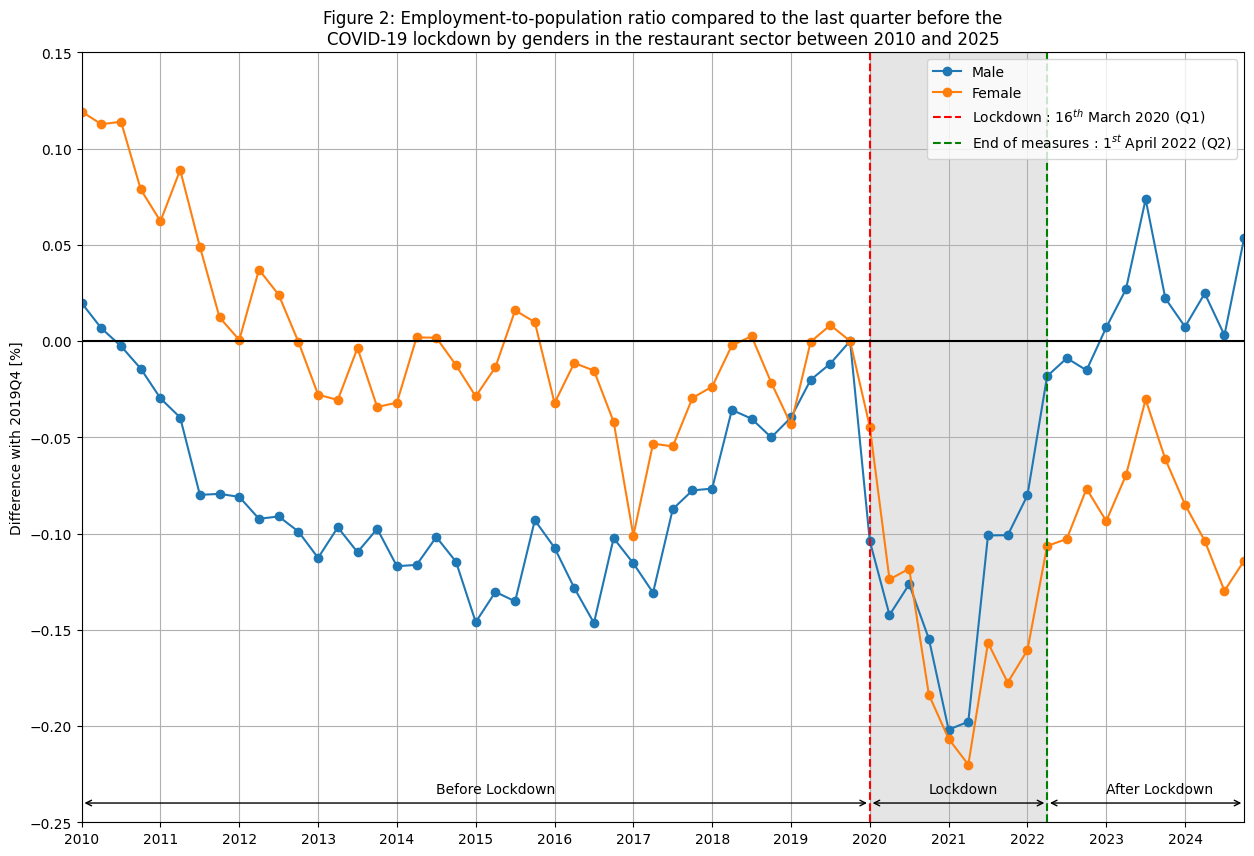

In [15]:
def plot_comparative(df : pd.DataFrame) -> None:
    """Plot the employement-to-population ratio compared to the last one before Lockdown for each gender
    
    :param df: The DataFrame with all the data
    :type df: pd.DataFrame"""
    before_covid_female = df.iloc[75, 2]
    before_covid_male = df.iloc[79, 2]
    time = np.linspace(0, 59, 60)
    _, ax = plt.subplots(figsize=(15, 10))
    ax.plot(time, df.loc[df["Female"]==0, "Employment-to-population Ratio [%]"].to_numpy()/before_covid_male-1, marker="o", label="Male")
    ax.plot(time, df.loc[df["Female"]==1, "Employment-to-population Ratio [%]"].to_numpy()/before_covid_female-1, marker="o", label="Female")
    ax.axvline(40, c="r", ls="--", label="Lockdown : $16^{th}$ March 2020 (Q1)")
    ax.axvline(49, c="green", ls="--", label="End of measures : $1^{st}$ April 2022 (Q2)")
    ax.axvspan(40, 49, color="grey", alpha=0.2)
    ax.hlines(0, xmin=0, xmax=59, color="k")

    plt.annotate(text='', xy=(40,-0.24), xytext=(0,-0.24), arrowprops=dict(arrowstyle='<->'))
    plt.annotate(text='Before Lockdown', xy=(18,-0.235), xytext=(18,-0.235))
    plt.annotate(text='', xy=(49,-0.24), xytext=(40,-0.24), arrowprops=dict(arrowstyle='<->'))
    plt.annotate(text='Lockdown', xy=(43,-0.235), xytext=(43,-0.235))
    plt.annotate(text='', xy=(59,-0.24), xytext=(49,-0.24), arrowprops=dict(arrowstyle='<->'))
    plt.annotate(text='After Lockdown', xy=(52,-0.235), xytext=(52,-0.235))

    plt.xlim(0, 59)
    plt.ylim(-0.25, 0.15)
    plt.xticks([i for i in time if i%4==0], labels=[f"20{10+i}" for i in range(15) for j in range(4) if j==0])
    plt.ylabel("Difference with 2019Q4 [%]")
    plt.legend(loc='upper right')
    plt.grid()
    plt.title("Figure 2: Employment-to-population ratio compared to the last quarter before the\nCOVID-19 lockdown by genders in the restaurant sector between 2010 and 2025")
    plt.show()

plot_comparative(df)

Figure 2 shows the employment-to-population ratio in the restaurant sector for women and men, normalized to the last pre-lockdown quarter (2019Q4), and expressed as deviations from that baseline, allowing a direct comparison of relative employment losses and recovery paths.<br><br>
Prior to 2020, women consistently exhibit higher employment levels than men, although the gender gap appears to narrow slightly, seemingly driven by a decline in women’s employment-to-population ratio and a simultaneous increase for men.<br><br>
At the onset of the COVID-19 lockdown, employment drops sharply for both genders, with larger negative deviations for women. In 2020Q3, the women’s curve falls below that of men, signaling a widening of the gender employment gap relative to the pre-COVID baseline.<br><br>
During the recovery phase, gender differences persist. Men’s employment rebounds more quickly and returns close to, or above, pre-pandemic levels, while women’s employment remains persistently below baseline, indicating a slower and incomplete recovery.<br><br>
Taken together, these patterns show that COVID-19 disrupted employment for both genders, while women suffered larger losses and a slower recovery.
<br><br>
Overall, these visual patterns are descriptive rather than causal, but they set the table for the analysis that follows.

## The Main Dish: Methodology & Discussion ou Methodology & Results
Moving to the main course of our empirical analysis, we rely on a difference-in-differences framework to guide our estimation strategy. This initial specification serves as our baseline regression and sets the stage for the analysis. We then extend this framework using an event-study design, which allows us to examine the temporal structure of the estimated effects.
Throughout the analysis, ** and *** denote statistical significance at the 5% and 1% levels, respectively, and all coefficients are expressed in percentage points referred to as pp.
### Preheating the Oven: Assessing Pre-Trends and Identification
Before starting to cook the main dish, the oven needs to be properly pre-heated to ensure reliable results. In empirical terms, this corresponds to verifying that the conditions for causal inference are met by assessing the parallel trends assumption, namely whether women and men followed comparable employment trends prior to the COVID-19 shock. To do so, we implement a placebo difference-in-differences regression using only pre-pandemic data. Specifically, we treat the period from 2017Q3 to 2019Q4 as a placebo post-period and compare it to an earlier pre-placebo period. The interaction between the female indicator and the placebo post period is statistically significant and negative, implying that women’s employment-to-population ratio was 0.10*** pp lower than men’s during the placebo period. This result indicates a violation of the parallel trends assumption, suggesting that employment trajectories for women and men were already diverging prior to the COVID-19 shock. As a consequence, attributing the estimated effects in the main regressions entirely to the pandemic is challenging, since part of the observed differences may reflect pre-existing dynamics rather than the COVID-19 shock alone. (See Appendix 3)

In [16]:
# restrict to pre-pandemic only (<= 2019Q4)
t_real = (2020 - df["Year"].min())*4  # 2020Q1
pre = df[df["N_Quarter"] < t_real].copy()

# Pick a placebo start date. Here: 2017Q3
t_placebo = (2014 - df["Year"].min())*4+2  # 2017Q3 -> 10 quarters long (same lenght as Covid-19: 2020Q1 to 2022Q2)
pre["PlaceboPost"] = (pre["N_Quarter"] >= t_placebo).astype(int)

formula_placebo = r"Q('Employment-to-population Ratio [%]') ~ Female + C(time) + Female:PlaceboPost"

m_placebo = smf.ols(formula_placebo, data=pre).fit(cov_type="HAC", cov_kwds={"maxlags": 4})

### Cooking the Dish: Difference-in-Differences Analysis
With the oven now pre-heated, we begin the main dish of our empirical analysis by estimating a difference-in-differences model comparing the pre-COVID to the lockdown period. This step provides a first assessment of whether the pandemic was associated with an immediate widening of the gender employment gap in the restaurant sector.
We estimate the following model using ordinary least squares with heteroscedasticity-robust standard errors:

$$\text{Employment-to-population}_{g, t, q} = \alpha+\beta_1\text{Female}_g+\beta_2\text{Lockdown}_t+\beta_3\left(\text{Female}_g\times\text{Lockdown}_t\right)+ \sum_{q=1}^{4}\gamma_q\text{Quarter}_q+\varepsilon_{g, t, q}$$
- $\text{Employment-to-population}_{g,t}:$ Employment-to-population ratio for gender $g \in \left\{\text{Female}, \text{Male} \right\}$ observed at year–quarter t.
- $\text{Female}_g:$ Dummy indicator equal to 1 if $g=\text{Female}$ and 0 if $g=\text{Male}$.
- $\text{Lockdown}_t:$ Dummy indicator equal to 1 for year–quarters t affected by COVID-19 lockdown measures.
- $\gamma_q​:$ Time fixed effects capturing seasonal variation across quarters $q \in \left\{Q1,Q2,Q3,Q4 \right\}$
- $\varepsilon_{g,t}:$​ Error term capturing unobserved factors.

During the lockdown, employment declined for both men and women in the restaurant sector, but the drop was substantially larger for women. The estimates indicate that men’s employment-to-population ratio decreased by 0.1054** pp during the lockdown period. Women experienced an additional decline of 0.3182*** pp relative to men, indicating a marked widening of the gender employment gap. The adjusted $R^2$ of 0.814 suggests that the model explains a large share of the variation in employment outcomes.

However, in light of the earlier evidence of diverging pre-pandemic trends, this estimate should not be interpreted as capturing the causal impact of COVID-19 alone. Rather, it reflects the combined effect of the pandemic shock and underlying dynamics that were already affecting women’s employment prior to COVID-19. The results nonetheless suggest that the pandemic acted as a powerful amplifier, leading to a substantially larger gender employment gap during the lockdown period.

In [17]:
formula_did = r"Q('Employment-to-population Ratio [%]') ~ Female + Lockdown + Female:Lockdown + C(Quarter)"

print(formula_did)
simple_did = smf.ols(formula_did, data=df.loc[df["After_Lockdown"]==0]).fit(cov_type="HC1")
print(simple_did.summary())

Q('Employment-to-population Ratio [%]') ~ Female + Lockdown + Female:Lockdown + C(Quarter)
                                       OLS Regression Results                                      
Dep. Variable:     Q('Employment-to-population Ratio [%]')   R-squared:                       0.825
Model:                                                 OLS   Adj. R-squared:                  0.814
Method:                                      Least Squares   F-statistic:                     73.26
Date:                                   ven., 19 déc. 2025   Prob (F-statistic):           4.54e-33
Time:                                             13:13:02   Log-Likelihood:                 67.503
No. Observations:                                      100   AIC:                            -121.0
Df Residuals:                                           93   BIC:                            -102.8
Df Model:                                                6                                         
Covarianc

### Tasting the Dish: Dynamic Effects Over Time
With the main dish now prepared, we move to the final stage: tasting it slowly to see how the flavours evolve and whether they leave a lasting aftertaste.<br><br>
While the DiD estimates capture the direct impact of the lockdown period, we now turn to an event-study analysis to examine how the gender employment gap evolved over time before, during, and after COVID-19. This approach allows us to assess whether the observed widening of the gender gap reflects a temporary disruption or more persistent dynamics.

#### Event study specification
We create a series of indicators that place each observation in time relative to the COVID-19 shock (before, during, and after). The period before 2018 is left out of the regression and serves as the reference group. All estimated coefficients therefore measure how employment outcomes at each point in time differ from this pre-pandemic reference period.
We distinguish five event-time periods:
- Two_Years_Before : The 4 quarters of 2018 (two years before COVID-19),
- One_Year_Before: The 4 quarters of 2019 (one year before COVID-19),
- Lockdown: The quarters affected by major containment measures,
- One_Year_After: The 4 quarters in the first year following the lifting of restrictions,
- Two_Years_After: The 4 quarters in the second year following the lifting of restrictions

To ensure a clean and consistent interpretation of post-pandemic dynamics, we restrict the estimation sample by excluding the two last quarters of 2024 (Q3 and Q4). This choice enhances the interpretation of the “Two_Years_After” category, which then corresponds to a complete two-year post period rather than being diluted with additional quarters<br><br>

We estimate the following model using ordinary least squares with heteroscedasticity-robust standard errors:

$\text{Employment-to-population}_{g, t, q} = \alpha+\beta_1\text{Female}_g+\beta_2\text{TwoYearBefore}_t+\beta_3\text{OneYearBefore}_t+\beta_4\text{DuringLockdown}_t+\beta_5\text{OneYearAfter}_t+\beta_6\text{TwoYearAfter}_t+\delta_1\left(\text{Female}_g\times\text{TwoYearBefore}_t\right)+\delta_2\left(\text{Female}_g\times\text{OneYearBefore}_t\right)+\delta_3\left(\text{Female}_g\times\text{DuringLockdown}_t\right)+\delta_4\left(\text{Female}_g\times\text{OneYearAfter}_t\right)+\delta_5\left(\text{Female}_g\times\text{TwoYearAfter}_t\right)+\sum_{q=1}^{4}\gamma_q\text{Quarter}_q+\varepsilon_{g, t, q}$

Quarter fixed effects control for recurring seasonal patterns in restaurant activity. The coefficients of interest are the interaction terms $\delta_k$​, which measure how the gender employment gap evolves at each event-time relative to the pre-COVID baseline. 

In [18]:
formula_es = r"Q('Employment-to-population Ratio [%]') ~ Female + Two_Years_Before + One_Year_Before + Lockdown + One_Year_After + Two_Years_After + Female:Two_Years_Before + Female:One_Year_Before + Female:Lockdown + Female:One_Year_After + Female:Two_Years_After  + C(Quarter)"

print(formula_es)
eventstudy_did = smf.ols(formula_es, data=df.loc[~df["time"].isin(["2024Q3", "2024Q4"])]).fit(cov_type="HC1")   #Exclure 2024Q3 et 2024Q4
print(eventstudy_did.summary())

Q('Employment-to-population Ratio [%]') ~ Female + Two_Years_Before + One_Year_Before + Lockdown + One_Year_After + Two_Years_After + Female:Two_Years_Before + Female:One_Year_Before + Female:Lockdown + Female:One_Year_After + Female:Two_Years_After  + C(Quarter)
                                       OLS Regression Results                                      
Dep. Variable:     Q('Employment-to-population Ratio [%]')   R-squared:                       0.825
Model:                                                 OLS   Adj. R-squared:                  0.801
Method:                                      Least Squares   F-statistic:                     81.37
Date:                                   ven., 19 déc. 2025   Prob (F-statistic):           2.07e-48
Time:                                             13:13:02   Log-Likelihood:                 86.047
No. Observations:                                      116   AIC:                            -142.1
Df Residuals:                       

### Results: Dynamic evolution of the gender employment gap
#### Baseline gender difference
The coefficient on Female is positive and highly statistically significant (+0.56***pp), indicating that, on average in the pre-2018 period, women have a higher employment-to-population ratio than men in the restaurant sector.
#### Pre-pandemic periods
Two years before the pandemic, women’s employment-to-population ratio was about 0.13*** pp lower than men’s relative to the pre-2018 baseline, and this gap widened to about 0.20*** pp one year before COVID-19. These results indicate that the gender employment gap was already changing in the years leading up to the pandemic, with women experiencing a gradual relative decline before the COVID-19 shock.This finding is consistent with the placebo test results and confirms that the parallel trends assumption does not strictly hold in the pre-pandemic period.
#### Lockdown period
During the lockdown, the gender employment gap widens sharply. The negative lockdown coefficient (−0.0973** pp) reflects a decline in employment for men during the lockdown period. The additional negative interaction for women (−0.3363*** pp) indicates that women experienced a substantially larger employment loss than men over the same period. Overall, consistent with the DiD findings, the lockdown intensified pre-existing gender disparities in employment.
#### Post-pandemic period
While men’s employment-to-population ratio recovers after Covid, increasing by 0.2078*** pp one year after and 0.3203*** pp two years after, women experience a weaker recovery. Women’s employment dropped sharply during the lockdown (−0.4336 pp) and, although it improves afterward, it remains below the pre-Covid trend, with decreases of 0.2553 pp one year after and 0.2121 pp two years after. As a result, the gender gap widens over time: women’s employment is 0.4631*** pp lower than men’s one year after Covid and 0.5324*** pp lower two years after Covid, pointing to persistent and growing gender disparities in the post-pandemic period.
#### Interpretation
The adjusted $R^2$ indicates that about 80.1% of the variation in the employment-to-population ratio is accounted for by the model, supporting the credibility of the descriptive patterns identified in the event-study analysis.The results show a widening of the gender employment gap over time, which increases sharply during the lockdown and becomes even larger in the post-Covid period, reflecting the persistence of the crisis as men’s employment recovers faster than women’s. However, because the gender gap was already increasing in the pre-Covid years, these patterns should not be interpreted as a purely exogenous effect of Covid-19, but rather as an amplification of pre-existing trends.

## Plating the Dish: Key Findings
We now serve the main dish by summarizing the key findings of our analysis.<br><br>
Our findings hint at a potential causal effect of the Covid-19 crisis on the amplification of the gender employment gap during the lockdown, with effects persisting in the post-Covid period.<br><br>
First, the gender employment gap widens sharply during the lockdown, driven by substantially larger employment losses for women than for men. This pattern is consistently observed across both the difference-in-differences and event-study results.<br><br>
Second, this widening persists after restrictions are lifted. Men’s employment not only recovers but rises above its pre-Covid levels, while women experience a weaker and incomplete recovery, resulting in a larger and more persistent gender employment gap over time.<br><br>
Finally, these findings should be interpreted with caution. Because gender-specific employment trends were already diverging prior to Covid-19, the pandemic cannot account for the full magnitude of the observed gender gap, but rather appears to have amplified pre-existing dynamics.
## From a Well-Prepared Dish to a Three-Star Restaurant: Limitations and Extensions
Beyond the data-related limitations discussed earlier, this section focuses on the interpretational limits of our empirical strategy and on how future research could address them.
### Unobserved pre-existing dynamics
Although we document pre-pandemic trends, our models do not control for underlying factors that may have shaped gender-specific employment dynamics prior to COVID-19, such as changes in job quality, working hours, contract stability, or preferences for work–life balance. In a sector characterized by irregular schedules, physically demanding tasks, and low wages, these factors may have already weakened women’s attachment to restaurant jobs. The COVID-19 shock may therefore have amplified, rather than initiated, these dynamics. With richer data, future research could incorporate controls for job characteristics, household constraints, or broader labour market conditions to better isolate these channels.
### Sector-specific interpretation and potential sectoral reallocation
Our analysis is confined to the restaurant sector and does not capture movements across sectors. As a result, the observed widening of the gender employment gap may partly reflect sectoral reallocation rather than pure job destruction. In particular, the pandemic may have acted as a moment of realization, accelerating exits from a sector widely perceived as demanding and insecure. FSO data indicate that the restaurant sector is among the lowest-paid in Switzerland, with a median monthly wage of CHF 4,479 in 2020 compared to CHF 6,665 nationally, and with women accounting for 63.5% of low-wage workers. [3] The COVID-19 shock may therefore have disproportionately encouraged durable exits from the sector among women.Tracking workers as they move across sectors would help distinguish employment losses within the restaurant sector from reallocation in the labour market.
### Limited granularity and heterogeneity
Our analysis relies on an aggregated gender–quarter panel of ~120 observations, which limits statistical power and constrains the complexity of feasible specifications. This aggregation prevents the analysis of heterogeneous responses across occupations, working-time arrangements, or contract types. Although managerial positions likely represent a small share of restaurant employment, access to occupational-level data would allow separate DiD estimates for total employment, managerial positions, and non-managerial workers. Such disaggregation would help isolate employment dynamics among non-managerial workers and reduce potential bias related to differential exposure to generative AI and task automation.

Overall, the analysis presents a well-prepared dish, highlighting gender-differentiated employment dynamics in the restaurant sector, while inviting further refinement of the recipe to better understand mechanisms, worker sorting, and wider labour-market adjustments.

## Appendix
$\text{Appendix }1:$ Data description
| Variable | Source | Description |
| --- | --- | --- |
| $\text{Employment}^{\text{restaurant}}$ | Jobs by economic division, employment level and sex (restaurant sector, quarterly, by gender) : FSO | Number of workers, by gender, in the restaurant sector each quarter between 2010Q1 and 2024Q4 |
| $\text{Working-age population}$ | Permanent resident population by year and sex, from which we extract the working-age population by gender : FSO | Population size of people being 15+ years old, by gender, each year |

$\text{Appendix }2:$ Data visualisation

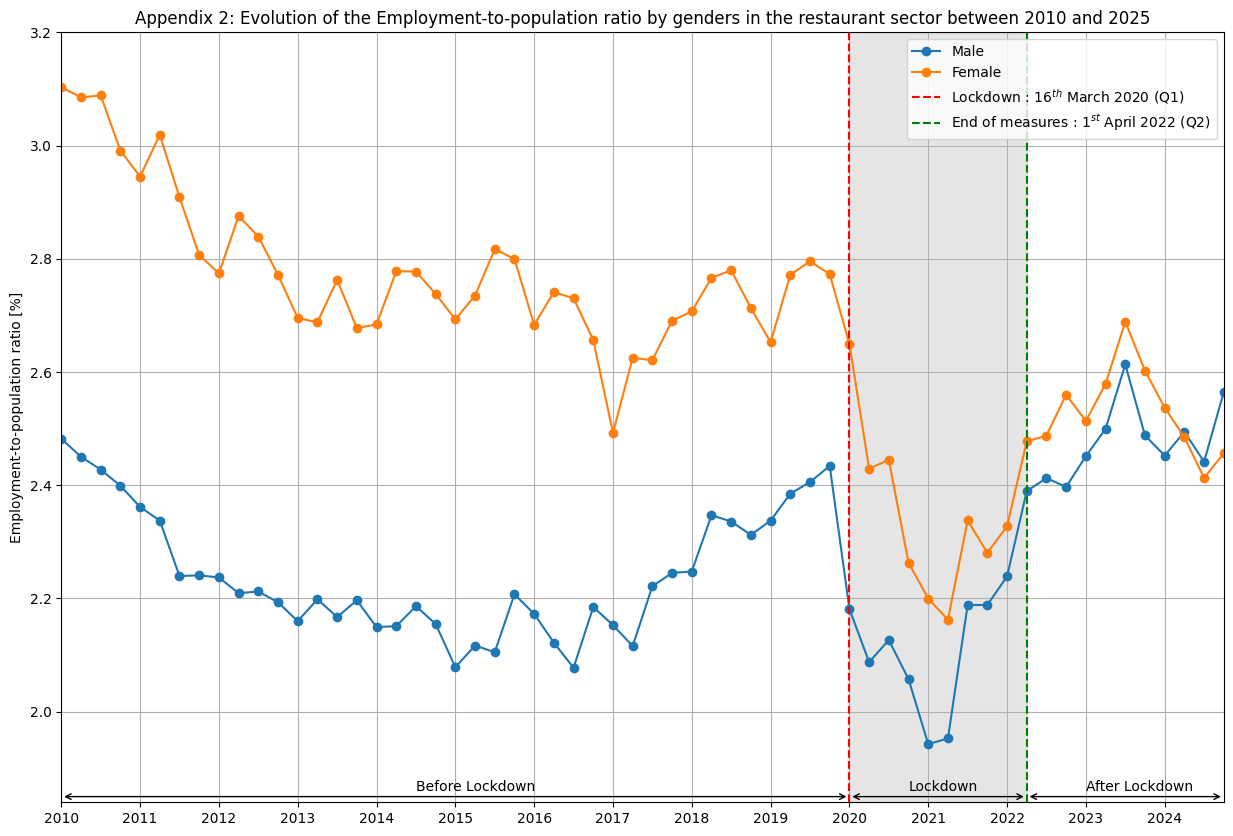

In [19]:
def plot_ratio(df : pd.DataFrame) -> None:
    """Plot the evolution of the employement-to-population ratio for each gender
    
    :param df: The DataFrame with all the data
    :type df: pd.DataFrame"""
    time = np.linspace(0, 59, 60)
    _, ax = plt.subplots(figsize=(15, 10))
    ax.plot(time, df.loc[df["Female"]==0, "Employment-to-population Ratio [%]"], marker="o", label="Male")
    ax.plot(time, df.loc[df["Female"]==1, "Employment-to-population Ratio [%]"], marker="o", label="Female")
    ax.axvline(40, c="r", ls="--", label="Lockdown : $16^{th}$ March 2020 (Q1)")
    ax.axvline(49, c="green", ls="--", label="End of measures : $1^{st}$ April 2022 (Q2)")
    ax.axvspan(40, 49, color="grey", alpha=0.2)

    plt.annotate(text='', xy=(40,1.85), xytext=(0,1.85), arrowprops=dict(arrowstyle='<->'))
    plt.annotate(text='Before Lockdown', xy=(18,1.86), xytext=(18,1.86))
    plt.annotate(text='', xy=(49,1.85), xytext=(40,1.85), arrowprops=dict(arrowstyle='<->'))
    plt.annotate(text='Lockdown', xy=(43,1.86), xytext=(43,1.86))
    plt.annotate(text='', xy=(59,1.85), xytext=(49,1.85), arrowprops=dict(arrowstyle='<->'))
    plt.annotate(text='After Lockdown', xy=(52,1.86), xytext=(52,1.86))

    plt.xlim(0, 59)
    plt.ylim(1.84, 3.2)
    plt.xticks([i for i in time if i%4==0], labels=[f"20{10+i}" for i in range(15) for j in range(4) if j==0])
    plt.ylabel("Employment-to-population ratio [%]")
    plt.legend(loc='upper right')
    plt.grid()
    plt.title("Appendix 2: Evolution of the Employment-to-population ratio by genders in the restaurant sector between 2010 and 2025")
    plt.show()

plot_ratio(df)

$\text{Appendix }3:$ Pre-trend check DiD

In [20]:
print(m_placebo.summary())

                                       OLS Regression Results                                      
Dep. Variable:     Q('Employment-to-population Ratio [%]')   R-squared:                       0.976
Model:                                                 OLS   Adj. R-squared:                  0.949
Method:                                      Least Squares   F-statistic:                 1.628e+04
Date:                                   ven., 19 déc. 2025   Prob (F-statistic):           1.11e-70
Time:                                             13:13:02   Log-Likelihood:                 132.60
No. Observations:                                       80   AIC:                            -181.2
Df Residuals:                                           38   BIC:                            -81.15
Df Model:                                               41                                         
Covariance Type:                                       HAC                                         


## References
[1] Dubois, C., Lambertini, L. & Wu, Y. (2022). Gender effects of the COVID-19 pandemic in the Swiss labor market. Swiss J Economics Statistics 158, 23 https://doi.org/10.1186/s41937-022-00099-z. 

[2] Lukić Nikolić, J., & Labus, P. (2025). An empirical study of the glass ceiling’s impact on gender equality and career opportunities in the food and beverage sector. Stanovništvo, 63(1), 51–72. https://doi.org/10.59954/stnv.634

[3] Le Temps. (2022). Postes à bas salaires toujours majoritairement occupés par des femmes. Le Temps. https://www.letemps.ch/economie/postes-bas-salaires-toujours-majoritairement-occupes-femmes

[4] Office fédéral de la statistique (OFS). (2020). Enquête suisse sur la population active (ESPA) : participation des femmes au marché du travail, 2010–2019. OFS. link: https://www.bfs.admin.ch/bfs/fr/home/statistiques/travail-remuneration/enquetes/espa.html

[5] Profeta P, Caló X, Occhiuzzi R.(2021).  COVID-19 and its economic impact on women and women’s poverty: Insights from five European countries. European Parliament 
Policy Department for Citizens’ Rights and Constitutional Affairs, Directorate-General for Internal Policies.link: https://www.europarl.europa.eu/thinktank/en/document/IPOL_STU(2021)693183 

[6] Reichelt, M., Makovi, K., & Sargsyan, A. (2021). The impact of COVID-19 on gender inequality in the labor market and gender-role attitudes. European Societies, 23(sup1), S228–S245. https://doi.org/10.1080/14616696.2020.1823010 

[7] Servoz, L., Stoevska, V., & Tumurchudur-Klok, B. (2025). Tourism jobs in the aftermath of the pandemic: skills and labour in short supply. ILOSTAT. https://ilostat.ilo.org/tourism-jobs-in-the-aftermath-of-the-pandemic-skills-and-labour-in-short-supply/


[8] USIDHR (US institute of diplomacy and human rights). (2022). How did the COVID-19 pandemic impact women and girls globally? https://usidhr.org/how-did-the-covid-19-pandemic-impact-women-and-girls-globally

[9] WKYC Channel 3. (2021). How the COVID-19 pandemic has impacted women’s jobs & the workforce gender equality gap [Video]. https://youtu.be/blOuuj_sNpk

[10] Müller, V. (2021). Une « récession au féminin » de courte durée. Avenir Suisse. https://www.avenir-suisse.ch/fr/une-recession-au-feminin-de-courte-duree/

[11] OpenAI. (2025). ChatGPT (GPT-5.2) [Large language model]. https://chat.openai.com/
Used for structural editing, language refinement, and clarity checks.

***
## Authors
-Ben Hamidane, Rania, SCIPER 415041<br>
-Bromet, Violaine, SCIPER 408154<br>
-Délez, Julien, SCIPER 313308